In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import functools 
import time
import datetime
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import tqdm

from matplotlib import pyplot as plt


### Часть первая: перенос стиля при помощи pix2pix

As I'm not very familiar with technicalities of architectures for CV applications I just shamelessly used [both generator and discriminator](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/tree/00d5574908eb66fe0127b32d7b030001453f21d0/models) from the authors of the original paper. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Downloading the dataset with separate images and masks

In [ ]:
DATASET_NAME = "CMP_facade_DB"
link = "http://cmp.felk.cvut.cz/~tylecr1/facade/"
for name in ["base", "extended"]:
    if not os.path.exists(f"{DATASET_NAME}_{name}.zip"):
        !wget "{link}{DATASET_NAME}_{name}.zip" -O "{DATASET_NAME}_{name}.zip"
        os.makedirs("datasets", exist_ok=True)
    !unzip "{DATASET_NAME}_{name}" -d "datasets/facade_{name}"

dataset_path = Path('datasets/facade_base/base')
for file_path in Path('datasets/facade_extended/extended').iterdir():
    file_path.rename(dataset_path / file_path.name)

In [4]:
count = 0
for file_path in dataset_path.iterdir():
    if file_path.suffix == ".jpg":
        count += 1
print(f"Total number of images {count}")

Total number of images 606


Preparing a dataset for the dataloader. I decided to follow notations A and B instead of image and mask respectively, as I saw it to be very common.

In [5]:
DATASET_PATH = "datasets/facade_base/base"

class Dataset:
    def __init__(self, path=DATASET_PATH, train=True, 
                 image_size=256, split_ratio=0.9):
        self.path = Path(path)
        self.train = train
        self.split_ratio = split_ratio        
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
        )

        imgs = sorted([f for f in self.path.iterdir() if f.suffix=='.jpg'])
        masks = sorted([f for f in self.path.iterdir() if f.suffix=='.png'])
        if self.train:
            self.imgs = imgs[:int(self.split_ratio * len(imgs))]
            self.masks = masks[:int(self.split_ratio * len(masks))]
        else:
            self.imgs = imgs[int(self.split_ratio * len(imgs)):]
            self.masks = masks[int(self.split_ratio * len(masks)):]        
        
    def __getitem__(self, idx):
        mask, img = (self.transform(
            Image.open(x[idx]).convert('RGB')) for x in [self.masks, self.imgs])        
        return {"A": img, "B" : mask}
        
    def __len__(self):
        return len(self.imgs)

For the generator I took the UNet one and discriminator is what the authors called the Patch discriminator. It does not give a single label, but classifies whether 70x70 intersecting patches are real or fake. In the case of 256x256 images the ouput has 30x30 dimensions.

In [6]:
class Identity(nn.Module):
    def forward(self, x):
        return x

def get_norm_layer(norm_type='instance'):
    """Return a normalization layer
    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        def norm_layer(x): return Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

def init_net(net, init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net -- network to be initialized
        init_gain (float) -- scaling factor for normal
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, init_gain)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1: 
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)
    return net

class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""
    def __init__(self, input_nc, output_nc, num_downs, ngf=64, 
                 norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, 
                                             input_nc=None, 
                                             submodule=None, 
                                             norm_layer=norm_layer, 
                                             innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, 
                                                input_nc=None, 
                                                submodule=unet_block, 
                                                norm_layer=norm_layer, 
                                                use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, 
                                             submodule=unet_block, 
                                             norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, 
                                             submodule=unet_block, 
                                             norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, 
                                             submodule=unet_block, 
                                             norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, 
                                             input_nc=input_nc, 
                                             submodule=unet_block, 
                                             outermost=True, 
                                             norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """
    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, 
                 norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

def define_G(input_nc=3, output_nc=3, ngf=8, 
            norm='batch', use_dropout=False, init_gain=0.02):
    norm_layer = get_norm_layer(norm_type=norm)
    net = UnetGenerator(input_nc, output_nc, 
                        num_downs=8, ngf, 
                        norm_layer=norm_layer, 
                        use_dropout=use_dropout)
    return init_net(net)

In [7]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial: # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        # gradually increase the number of filters
        for n in range(1, n_layers):  
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, mask, img):
        return self.model(torch.cat((mask, img), 1))

def define_D(input_nc=6, ndf=64, n_layers_D=3, norm='batch', init_gain=0.02):
    """Create a discriminator
    Parameters:
        input_nc (int)     -- the number of channels in input images
        ndf (int)          -- the number of filters in the first conv layer
        n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
        norm (str)         -- the type of normalization layers used in the network.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
    Returns a discriminator
    Our current implementation provides three types of discriminators:
        [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
        It can classify whether 70×70 overlapping patches are real or fake.
        Such a patch-level discriminator architecture has fewer parameters
        than a full-image discriminator and can work on arbitrarily-sized images
        in a fully convolutional fashion.
    """
    norm_layer = get_norm_layer(norm_type=norm)
    net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    return init_net(net, init_gain)

Checking that it works...

In [8]:
x = torch.ones((1, 3, 256, 256))
mask = torch.ones((1, 3, 256, 256))
g = define_G()
print(g(mask).shape)

torch.Size([1, 3, 256, 256])


In [9]:
d = define_D()
print(d(mask, x).shape)

torch.Size([1, 1, 30, 30])


Initializing everything and training

In [ ]:
EPOCHS = 200
BATCH_SIZE = 1
CHECKPOINT_STEPS = 10
SAMPLE_INTERVAL = 500
LR, BETA1, BETA2 = 2e-4, 0.5, 0.999
SAVE_PATH = f"/content/drive/MyDrive/Colab Notebooks/advanced_ml/HW3/batch_{BATCH_SIZE}"
# loss weight of L1 pixel-wise loss between generated image and real image
LAMBDA_PIXEL = 100
# output image size
patch = (1, 30, 30)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# loss functions
criterion_GAN = torch.nn.MSELoss().to(device)
criterion_pixelwise = torch.nn.L1Loss().to(device)
# dataloaders
train_dataset = Dataset()
test_dataset = Dataset(train=False)
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
# generator, discriminator and their optimizers
generator = define_G().to(device)
discriminator = define_D().to(device)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, BETA2))


def sample_images(epoch, batches_done):
    """Saves a generated sample from the validation set"""
    imgs = next(iter(test_dataloader))
    real_A = torch.FloatTensor(imgs["B"]).to(device)
    real_B = torch.FloatTensor(imgs["A"]).to(device)
    fake_B = generator(real_A)
    img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2)
    save_image(img_sample, 
               f"{SAVE_PATH}/images/{epoch}_{batches_done}.png", 
               nrow=5, normalize=True)

for epoch in range(EPOCHS):
    for i, batch in enumerate(train_dataloader):
        real_A = torch.FloatTensor(batch["B"]).to(device)
        real_B = torch.FloatTensor(batch["A"]).to(device)
        
        optimizer_G.zero_grad()
        # GAN loss
        fake_B = generator(real_A) # fake image
        pred_fake = discriminator(fake_B, real_A) # fake image + mask
        ones = torch.ones((real_A.size(0), *patch), 
                          requires_grad=False, 
                          dtype=torch.float32).to(device)
        loss_GAN = criterion_GAN(pred_fake, ones)
        # pixelwise loss between fake image and real image
        loss_pixel = criterion_pixelwise(fake_B, real_B) 
        # total generator loss
        loss_G = loss_GAN + LAMBDA_PIXEL * loss_pixel
        loss_G.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        zeros = torch.zeros((real_A.size(0), *patch), 
                            requires_grad=False, 
                            dtype=torch.float32).to(device)
        # loss on real examples
        pred_real = discriminator(real_B, real_A) # real image + mask
        loss_real = criterion_GAN(pred_real, ones)
        # loss on fake examples
        pred_fake = discriminator(fake_B.detach(), real_A) # fake_image + mask
        loss_fake = criterion_GAN(pred_fake, zeros)
        # total discriminator loss
        loss_D = 0.5 * (loss_real + loss_fake)
        loss_D.backward()
        optimizer_D.step()


        batches_done = epoch * len(train_dataloader) + i
        sys.stdout.write(
            f"\r[Epoch {epoch}]" + \
            f"[Batch {i}/{len(train_dataloader)}] [D loss: {loss_D.item()}]" + \
            f"[G loss: {loss_G.item()}, pixel loss: {loss_pixel.item()}, adv loss: {loss_GAN.item()}]"
        )
        if batches_done % SAMPLE_INTERVAL == 0:
            sample_images(epoch, batches_done)

    if epoch % CHECKPOINT_STEPS == 0:
        torch.save(generator.state_dict(), 
                   f"{SAVE_PATH}/checkpoints/generator_{epoch}.pth")
        torch.save(discriminator.state_dict(), 
                   f"{SAVE_PATH}/checkpoints/discriminator_{epoch}.pth")

[Epoch 197][Batch 462/545] [D loss: 1.8529370208852924e-05][G loss: 11.989747047424316, pixel loss: 0.10989421606063843, adv loss: 1.000325083732605]

Below are some generated images on the test examples. Earlier epochs are to the right, but honestly even after 200 epochs it doesn't look very good.

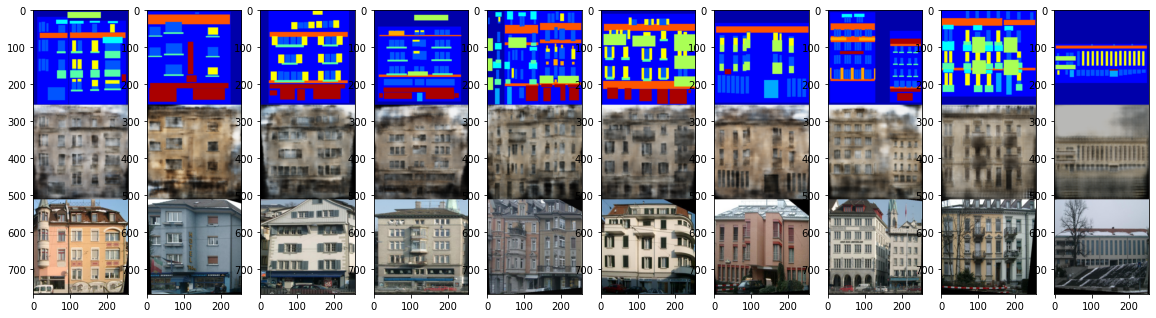

In [30]:
path = f"{SAVE_PATH}/images/"
generated_file_names = ["198_108000", "195_106500","192_105000", 
                        "169_92500", "162_88500", "155_85000", 
                        "155_84500", "82_45000", "25_14000", "9_5000"]
fg, ax = plt.subplots(1, len(generated_file_names), figsize=(20, 20))
for i, f in enumerate(generated_file_names):
    img = Image.open(f"{path}{f}.png").convert('RGB')
    ax[i].imshow(img)

I also did training with the same parameters but with a batch of 5, and it looks worse.

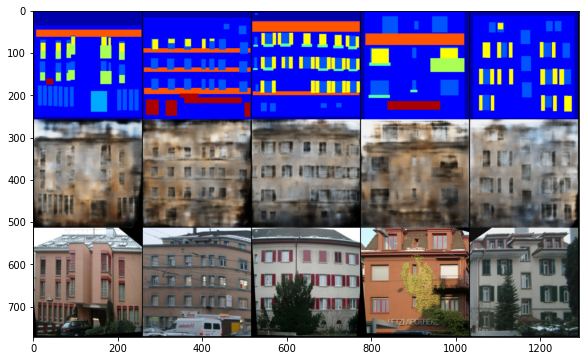

In [33]:
path = "/content/drive/MyDrive/Colab Notebooks/advanced_ml/HW3/images/"
fg, ax = plt.subplots(1, 1, figsize=(10, 6))
img = Image.open(f"{path}21700.png").convert('RGB')
ax.imshow(img)

It looks cooler for earlier epochs, but they are basically discolored masks.

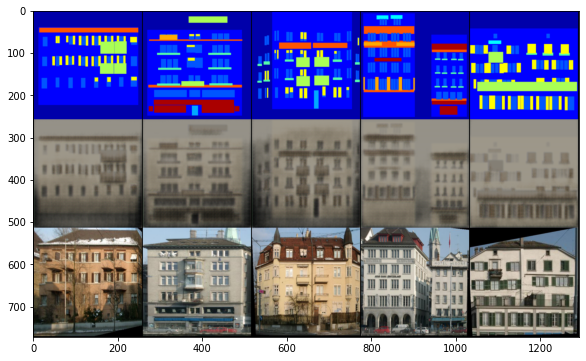

In [35]:
fg, ax = plt.subplots(1, 1, figsize=(10, 6))
img = Image.open(f"{path}500.png").convert('RGB')
ax.imshow(img)